# Determining Top Real Estate Zipcodes

In [3]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import itertools
import statsmodels.api as sm
import statistics as stats
from matplotlib.pylab import rcParams
from pandas import Grouper
from collections import Counter
plt.style.use('seaborn-bright')
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

# Importing Data and Preview

In [4]:
df = pd.read_csv('zillow_data.csv')

In [5]:
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Data Preprocessing

Converting to Time Series

In [6]:
pd.to_datetime(df.columns.values[7:], format='%Y-%m')

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

In [7]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
              ... 
2015-11          0
2015-12          0
2016-01          0
2016-02          0
2016-03          0
2016-04          0
2016-05          0
2016-06          0
2016-07          0
2016-08          0
2016-09          0
2016-10          0
2016-11          0
2016-12          0
2017-01          0
2017-02          0
2017-03          0
2017-04          0
2017-05          0
2017-06          0
2017-07          0
2017-08     

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


# Determining top 5 zip codes

Zipcodes where value increased most months.

In [9]:
def zip_increase(df, percent):
    increase = []
    intervals = []
    for row in range(len(df.RegionID)):
        zero = 0
        increasing = 0
        decreasing = 0
        zipcode = df.RegionName[row]
        for column in df.columns[7:]:
            one = df[column][row]
            if one > zero:
                increasing += 1
            else:
                decreasing += 1
            zero = one
        net = increasing - decreasing
        if net > 0:
            increase.append(zipcode)
            intervals.append(net)
    dic = {'Zipcode':increase, 'Positive_Intervals': intervals}
    increasedf = pd.DataFrame(dic)
    rank = percent * (len(df.columns) - 7)
    ziprank = increasedf.sort_values(by='Positive_Intervals', ascending=False)
    ziprank = ziprank[ziprank.Positive_Intervals >= rank]
    zips = list(ziprank['Zipcode'])
    return zips, ziprank
        

In [10]:
df2 = df.copy()

In [11]:
zips, ziprank = zip_increase(df2, .7)

In [12]:
ziprank

,Zipcode,Positive_Intervals
2740,37206,201
6045,37204,195
1357,80211,195
465,11216,195
1415,20003,195
4809,99502,191
1296,80210,189
2429,80521,189
6104,81101,187


# Reshape from Wide to Long Format

In [13]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['SizeRank','RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted.set_index('time',inplace=True)
    melted.dropna(inplace=True)
    return melted

In [14]:
zippedf = pd.DataFrame()
for z in zips:
    d = melt_data(df[df.RegionName==z])
    zippedf = pd.concat([d, zippedf])
zippedf.head()

,SizeRank,RegionID,RegionName,City,State,Metro,CountyName,value
time,,,,,,,,
1996-04-01,2492,93445,80521,Fort Collins,CO,Fort Collins,Larimer,113900.0
1996-05-01,2492,93445,80521,Fort Collins,CO,Fort Collins,Larimer,114200.0
1996-06-01,2492,93445,80521,Fort Collins,CO,Fort Collins,Larimer,114400.0
1996-07-01,2492,93445,80521,Fort Collins,CO,Fort Collins,Larimer,114700.0
1996-08-01,2492,93445,80521,Fort Collins,CO,Fort Collins,Larimer,115000.0


# EDA and Visualization

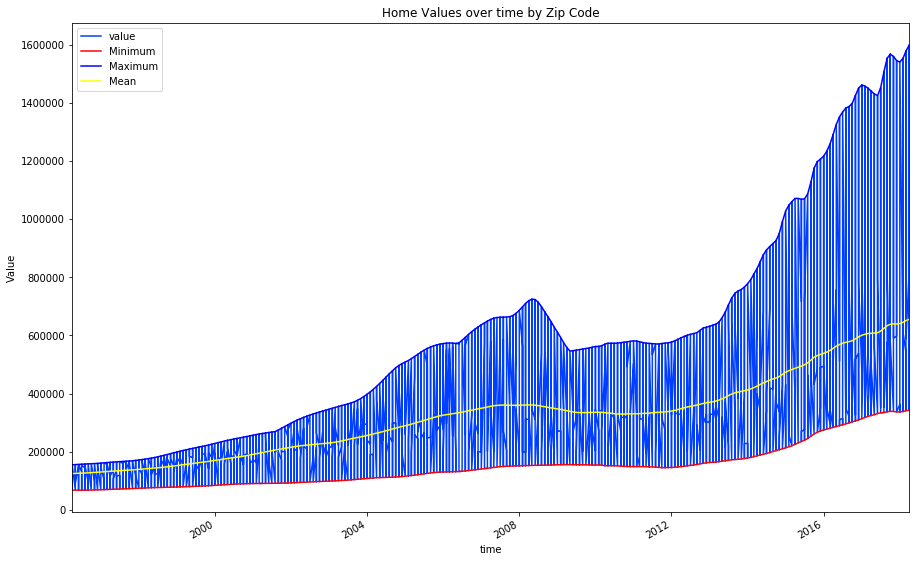

In [15]:
zippedf.value.plot(figsize=(15,10))
minimum = zippedf.groupby('time').aggregate({'value':'min'})
maximum = zippedf.groupby('time').aggregate({'value':'max'})
mean = zippedf.groupby('time').aggregate({'value':'mean'})
plt.plot(minimum, color='red', label='Minimum')
plt.plot(maximum, color='blue', label='Maximum')
plt.plot(mean, color='yellow', label='Mean')
plt.legend()
plt.title('Home Values over time by Zip Code')
plt.ylabel('Value')
plt.show()

# ARIMA Modeling

Stationarity Test

In [16]:
zipcodes1 = zippedf.RegionName.sort_values().unique()

In [17]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [18]:
for z in zipcodes1:
    df_z = zippedf[zippedf.RegionName == z]
    result = adfuller(df_z.value.dropna())
    print('Zip: ', z)
    print('ADF Statistic %f' % result[0])
    print('p-value: %f' % result[1])

Zip:  11216
ADF Statistic 0.203156
p-value: 0.972438
Zip:  20003
ADF Statistic -1.351554
p-value: 0.605269
Zip:  37204
ADF Statistic -0.192801
p-value: 0.939374
Zip:  37206
ADF Statistic -0.537058
p-value: 0.884580
Zip:  80210
ADF Statistic 0.789878
p-value: 0.991471
Zip:  80211
ADF Statistic 1.385263
p-value: 0.997046
Zip:  80521
ADF Statistic 0.196868
p-value: 0.972085
Zip:  99502
ADF Statistic -1.734797
p-value: 0.413279


We can reject the Null hypothesis as none of the statistics are less than .05, and state than none of these series are stationary. 

Difference and Autocorrelation Plots

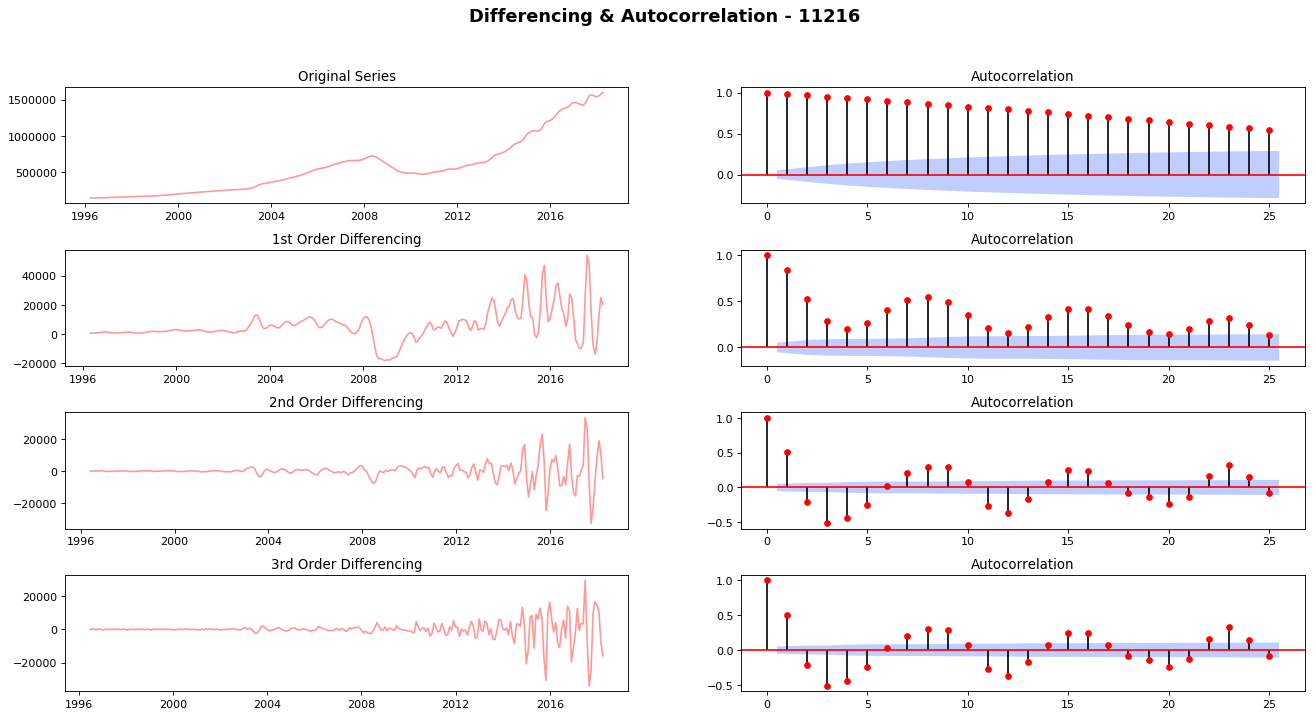

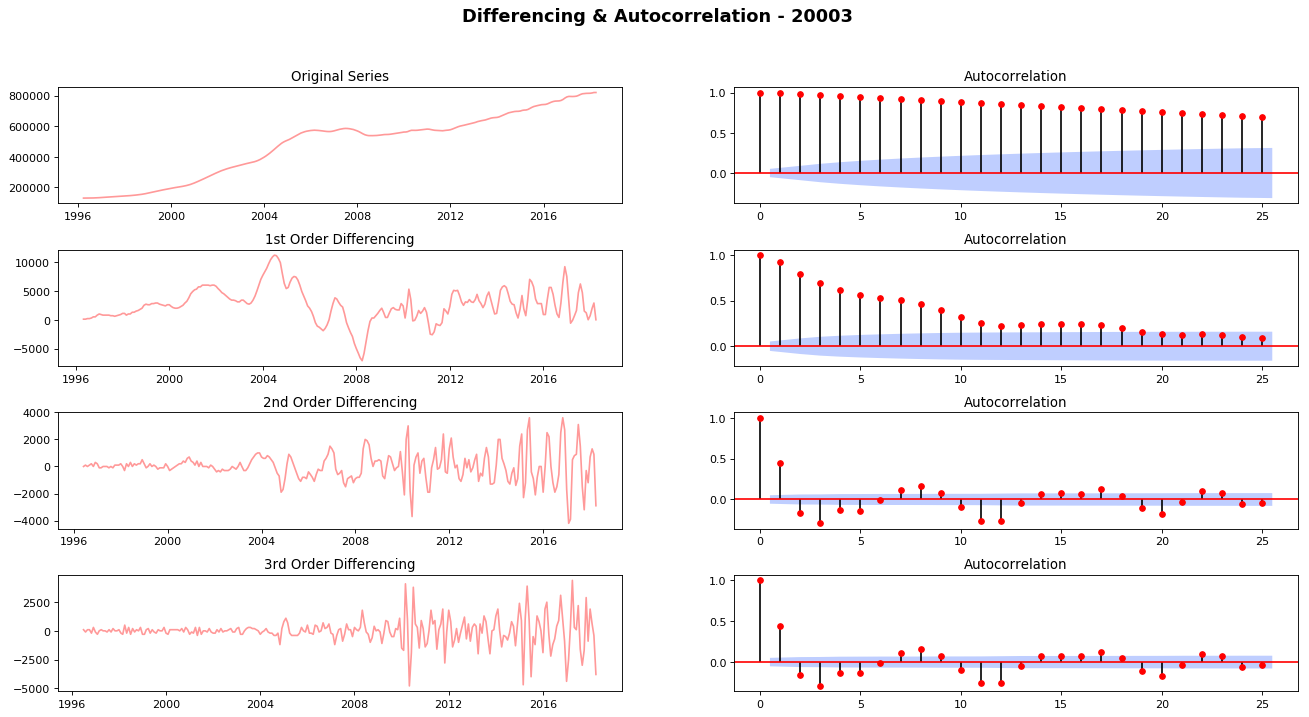

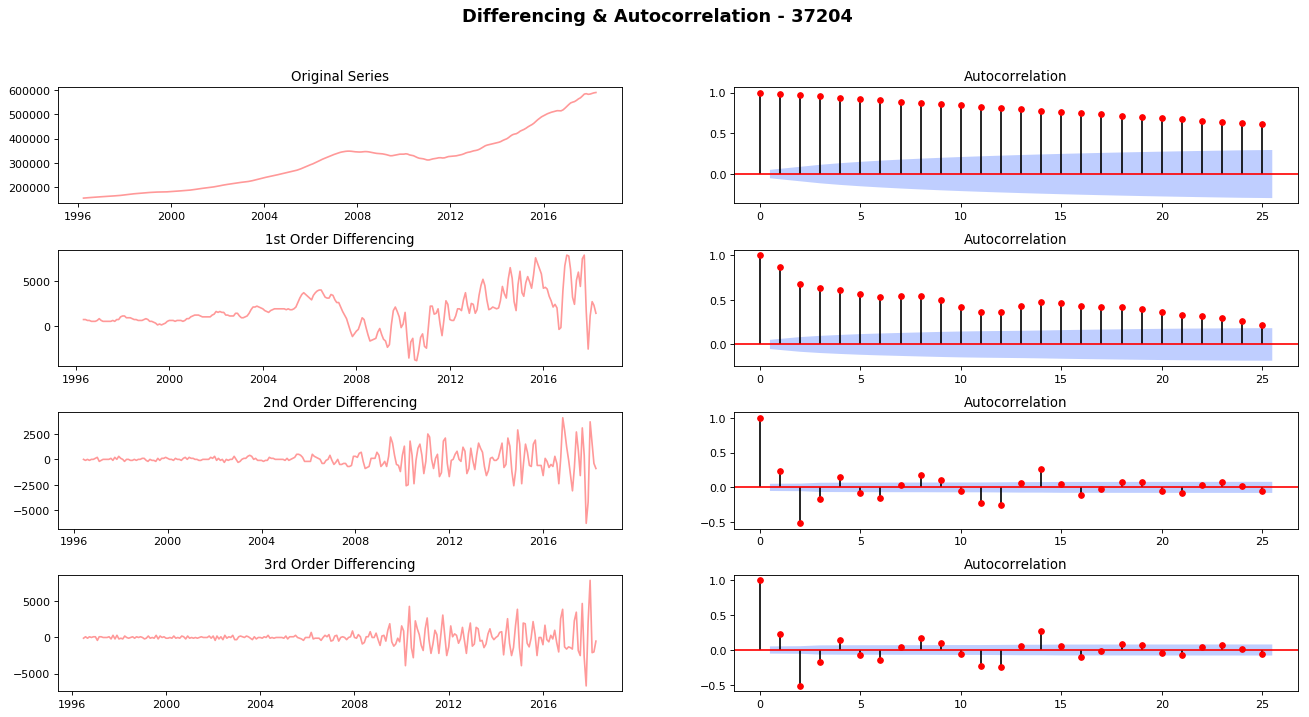

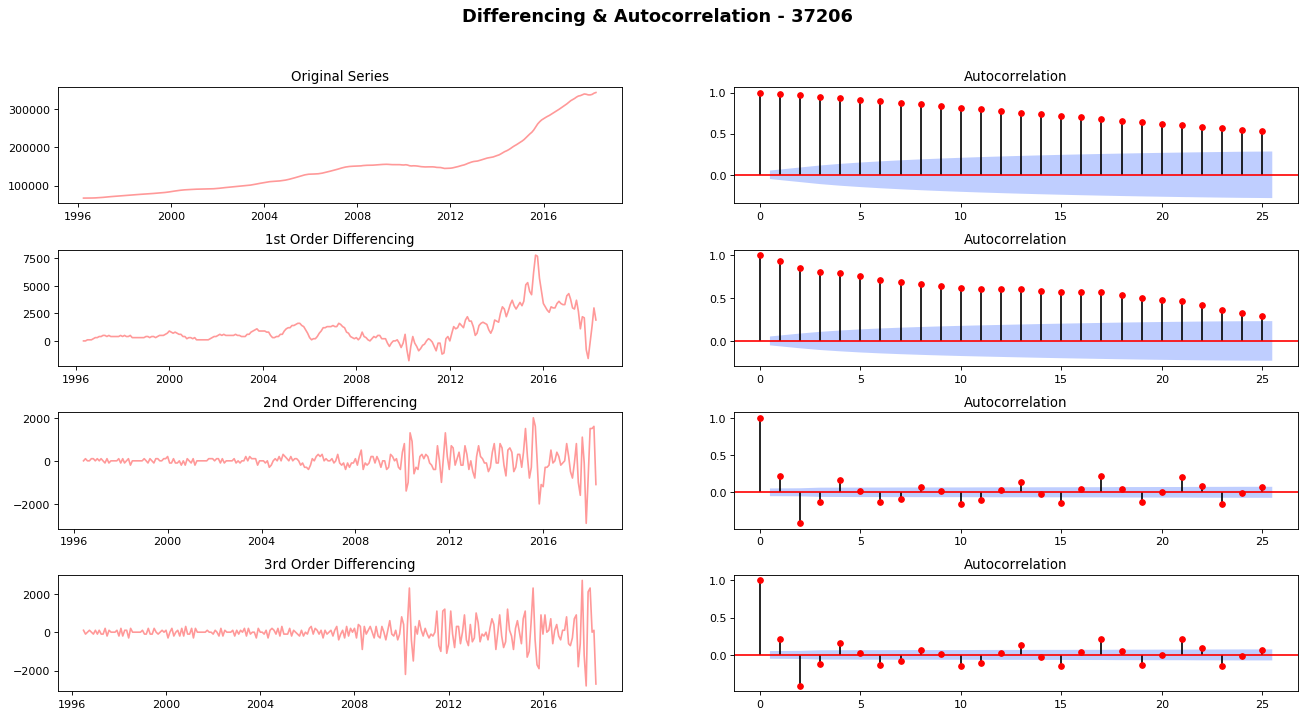

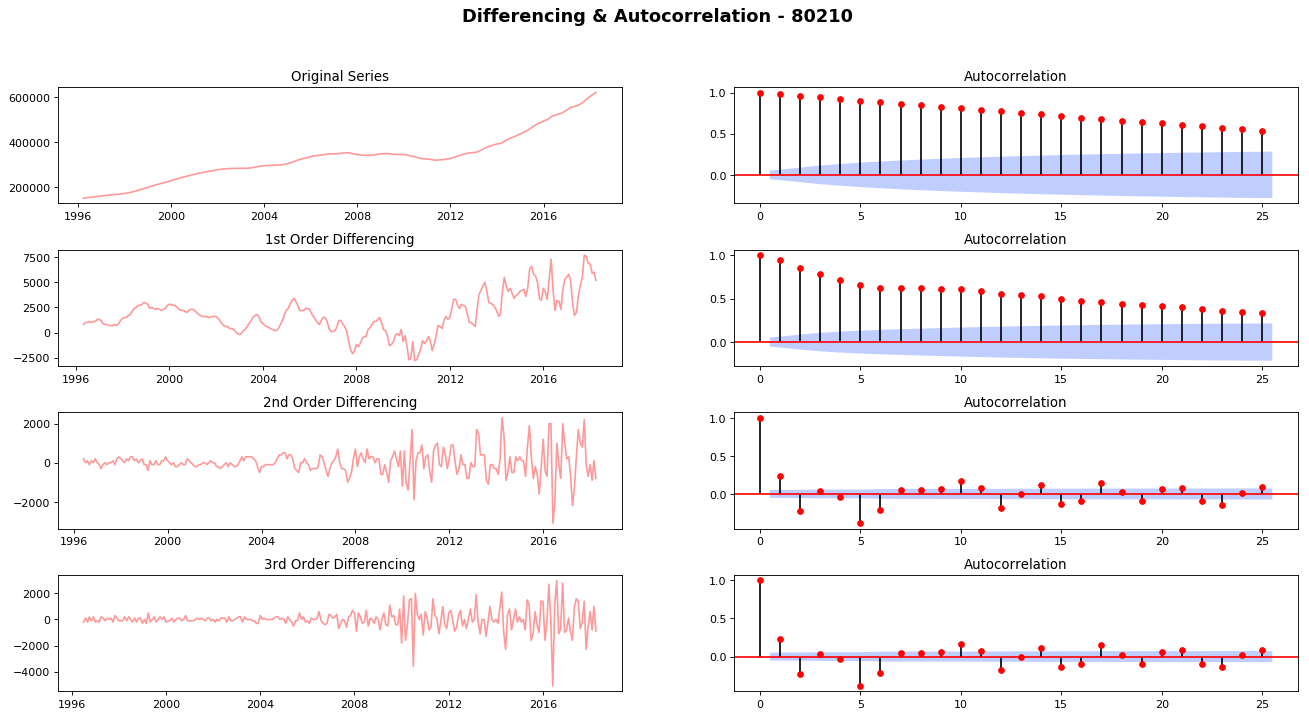

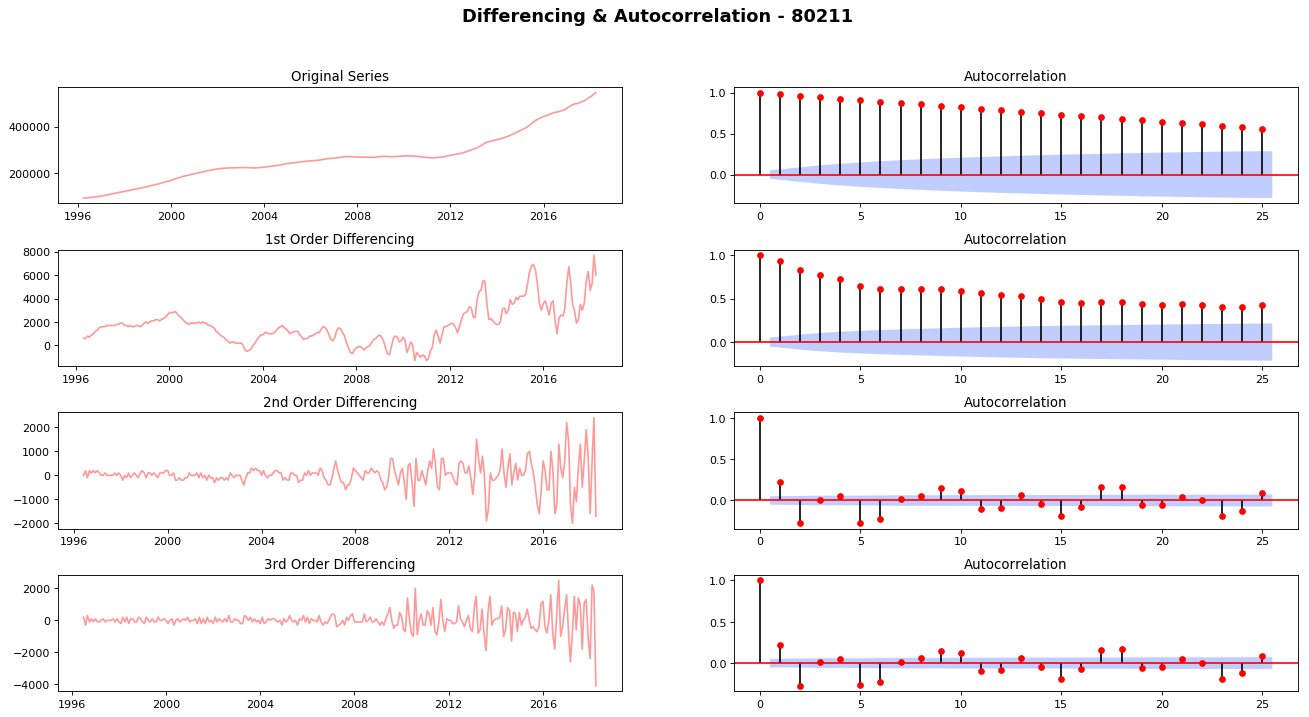

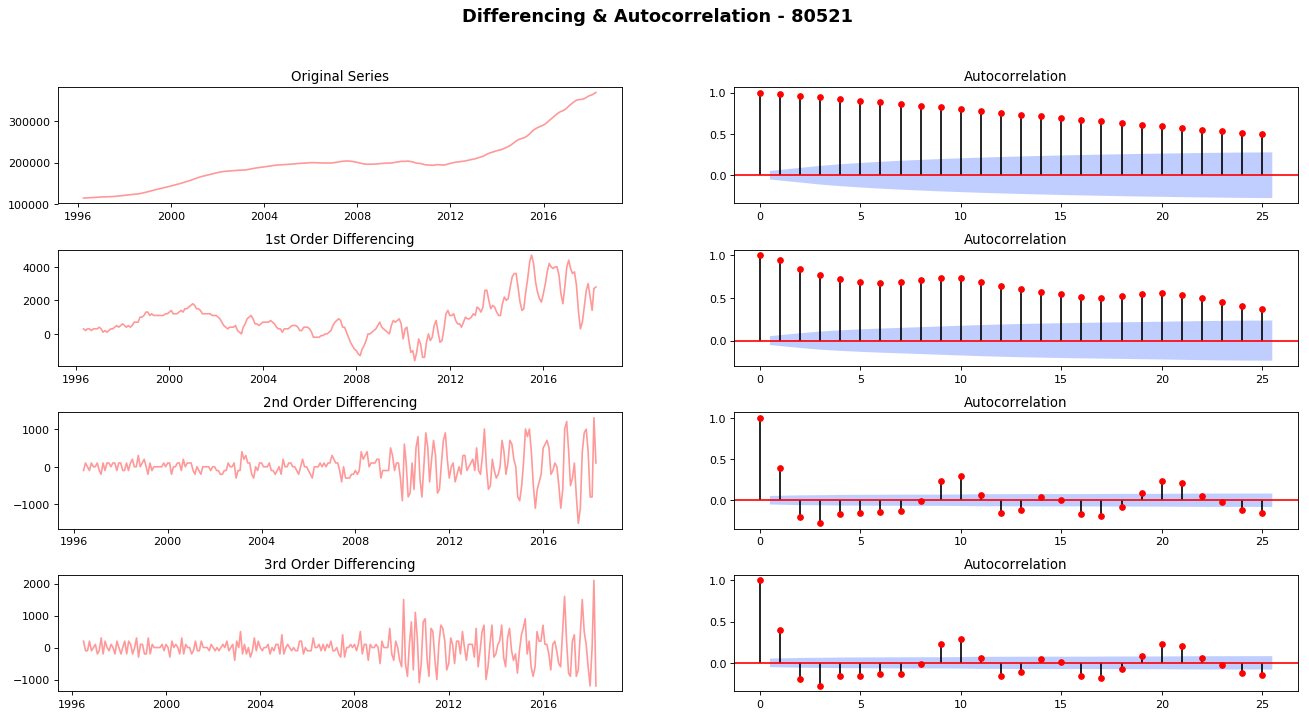

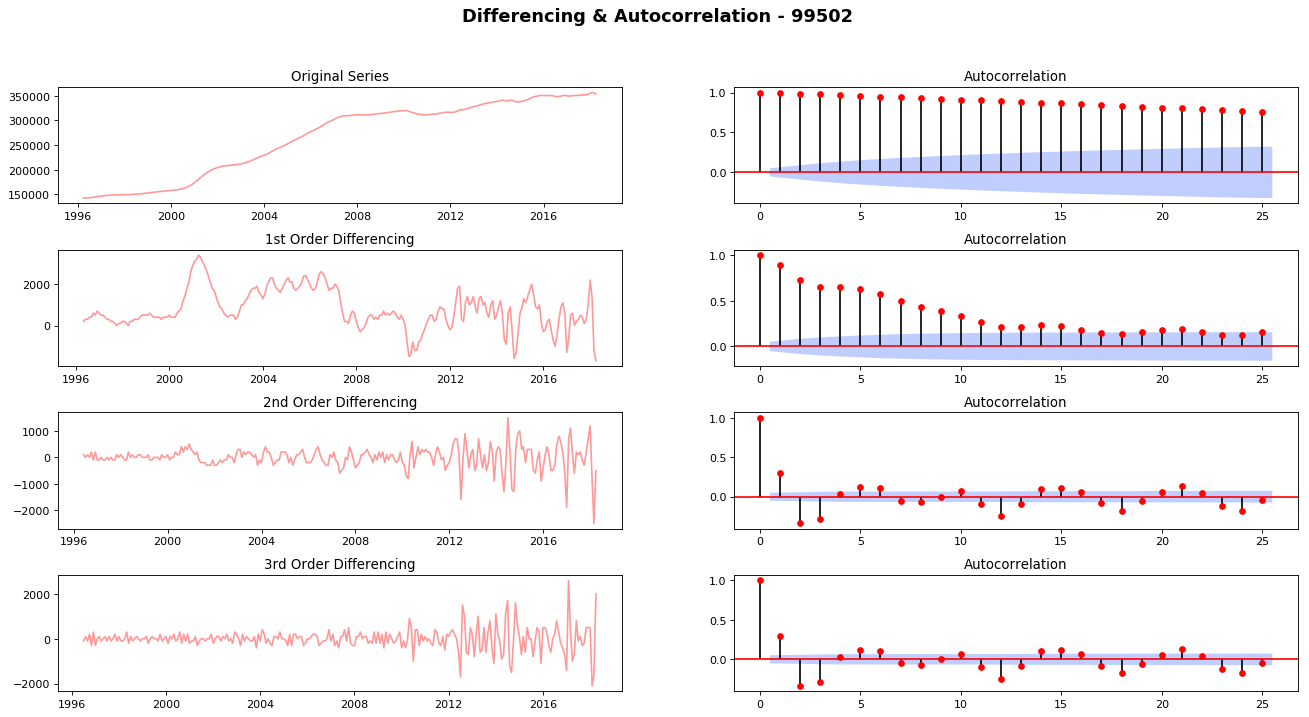

In [19]:
plt.rcParams.update({'figure.figsize': (20,10), 'figure.dpi':80})
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
for z in zipcodes1:
    df_z = zippedf[zippedf.RegionName==z]
    fig, axes = plt.subplots(4,2)
    axes[0, 0].plot(df_z.value,color='red',alpha=0.4); axes[0, 0].set_title('Original Series',fontsize=12)
    plot_acf(df_z.value, ax=axes[0, 1], color='red',alpha=0.4)

    # 1st Differencing
    axes[1, 0].plot(df_z.value.diff(), color='red',alpha=0.4); axes[1, 0].set_title('1st Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().dropna(), ax=axes[1, 1], color='red',alpha=0.4)

    # 2nd Differencing
    axes[2, 0].plot(df_z.value.diff().diff(), color='red',alpha=0.4); axes[2, 0].set_title('2nd Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().diff().dropna(), color='red',alpha=0.4, ax=axes[2, 1])
    
     # 3nd Differencing
    axes[3, 0].plot(df_z.value.diff().diff().diff(), color='red',alpha=0.4); axes[3, 0].set_title('3rd Order Differencing',fontsize=12)
    plot_acf(df_z.value.diff().diff().dropna(), ax=axes[3, 1],  color='red',alpha=0.4)

    fig.suptitle('Differencing & Autocorrelation - ' + str(z), fontsize=16, fontweight='bold')
    plt.subplots_adjust(hspace = 0.4 )
    plt.show()

Seasonal Decomposition, Model Building, Forecasting 

Zip:  11216
ADF Statistic Residual: -3.247510
p-value: 0.017394


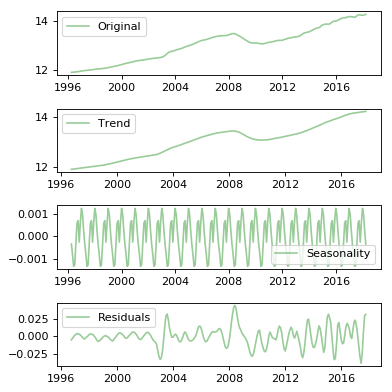

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=5289.617, BIC=5303.906, Fit time=0.364 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=5308.817, BIC=5315.961, Fit time=0.024 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=5293.275, BIC=5303.991, Fit time=0.059 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=5297.211, BIC=5307.927, Fit time=0.133 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=5290.711, BIC=5308.572, Fit time=0.682 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=5280.673, BIC=5298.533, Fit time=0.836 seconds
Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=5275.004, BIC=5300.009, Fit time=1.109 seconds
Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=5317.658, BIC=5339.091, Fit time=0.340 seconds
Fit ARIMA: order=(3, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=5314.358, BIC=5342.935, Fit time=1.164 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_o

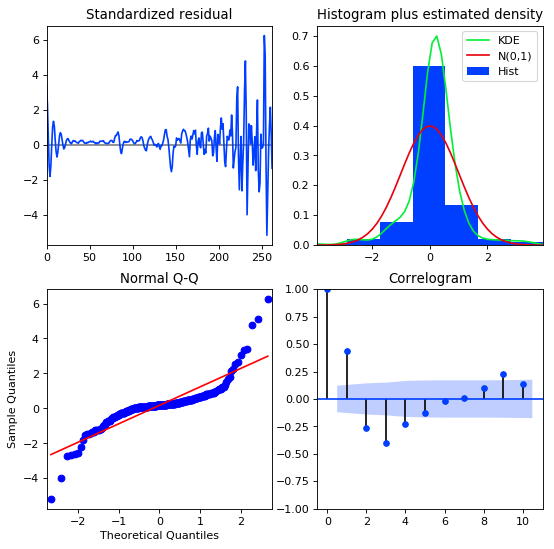

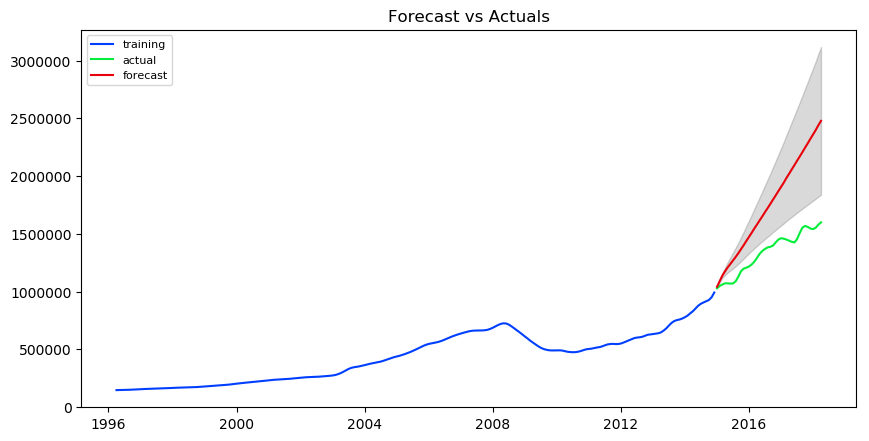

Mean Error : 415938.7587287204


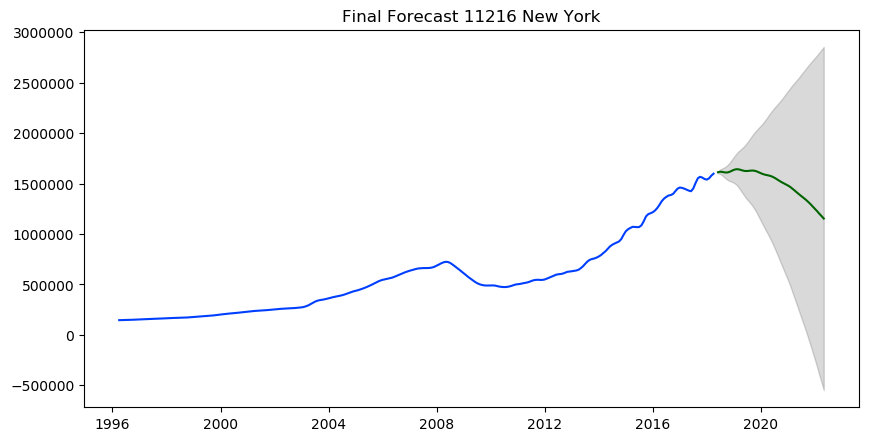

11216
Model Order:  (2, 2, 2)
Upside case 2022:  2855693.790860502 ROI:  77.0229503470588
Base   case 2022:  1154037.4477242902 ROI:  -28.46182792392992
Low    case 2022:  -547618.8954119217 ROI:  -133.94660619491862
Zip:  20003
ADF Statistic Residual: -6.039757
p-value: 0.000000


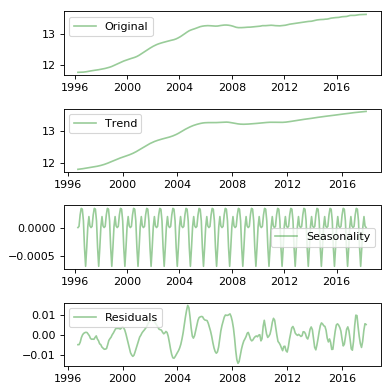

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4428.689, BIC=4442.978, Fit time=0.524 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4429.691, BIC=4436.836, Fit time=0.030 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4426.689, BIC=4437.405, Fit time=0.235 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4426.723, BIC=4437.439, Fit time=0.216 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4428.685, BIC=4442.974, Fit time=0.374 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4424.701, BIC=4442.562, Fit time=0.696 seconds
Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4438.517, BIC=4459.950, Fit time=1.014 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=4429.076, BIC=4450.509, Fit time=0.972 seconds
Fit ARIMA: order=(3, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=4455.831, BIC=4480.836, Fit time=1.052 seconds
Total fit time: 5.132 seconds
20003
 

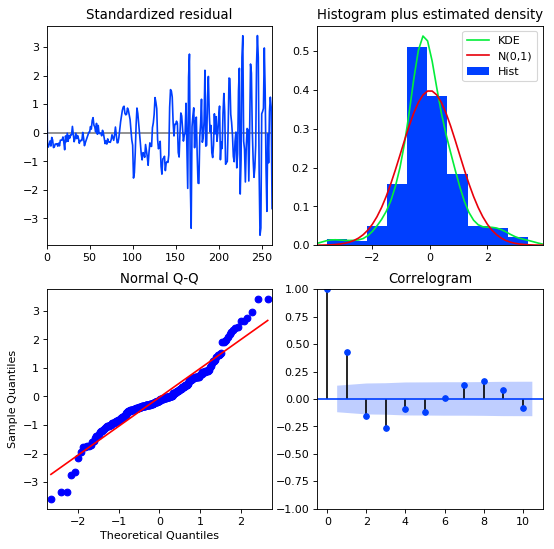

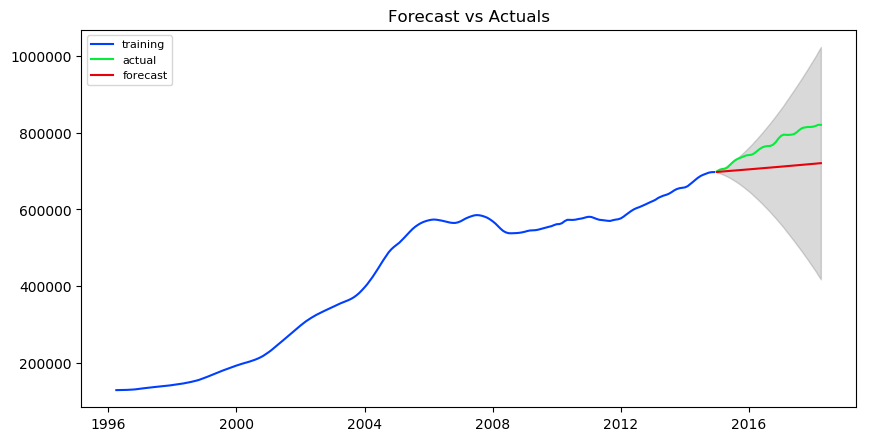

Mean Error : -57602.301015080266


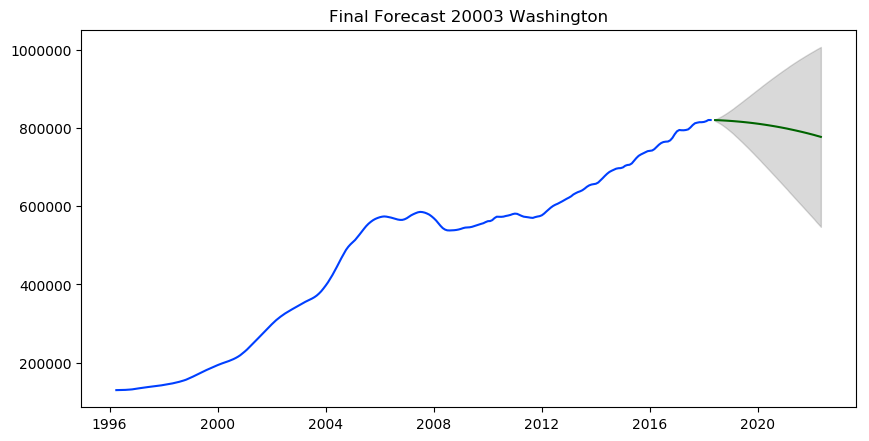

20003
Model Order:  (2, 2, 1)
Upside case 2022:  1006940.7761100705 ROI:  22.796279490371855
Base   case 2022:  777075.9464373838 ROI:  -5.235702667045981
Low    case 2022:  547211.116764697 ROI:  -33.267684824463814
Zip:  37204
ADF Statistic Residual: -4.199854
p-value: 0.000659


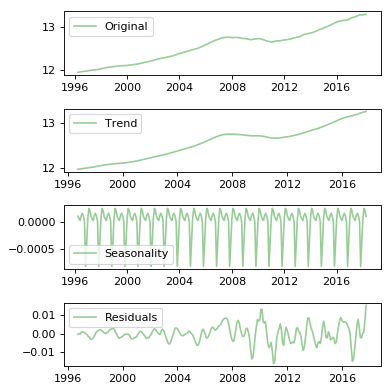

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4411.764, BIC=4426.053, Fit time=0.209 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4404.737, BIC=4411.881, Fit time=0.017 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4406.064, BIC=4416.781, Fit time=0.079 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4409.475, BIC=4420.192, Fit time=0.077 seconds
Total fit time: 0.406 seconds
37204
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2200.368
Date:                Mon, 11 Nov 2019   AIC                           4404.737
Time:                        11:49:24   BIC                           4411.881
Sample:                             0   HQIC                          4407.608
                                - 265                         

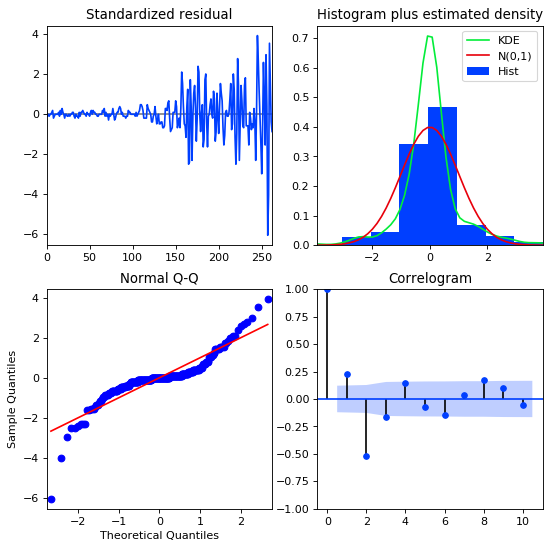

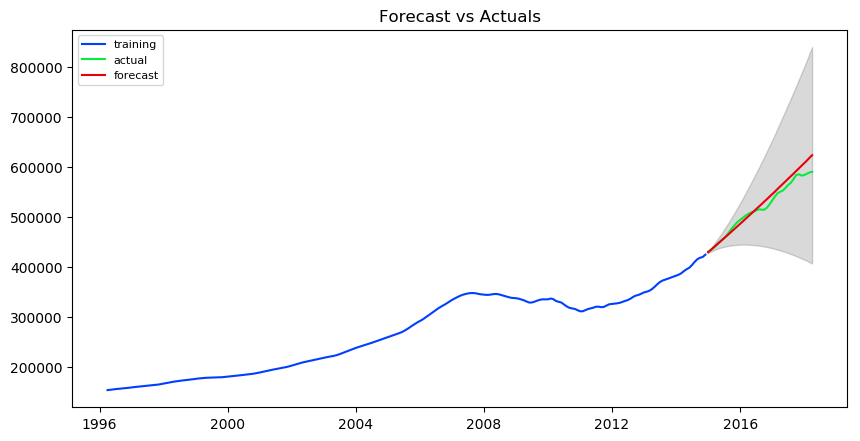

Mean Error : 6679.282511210772


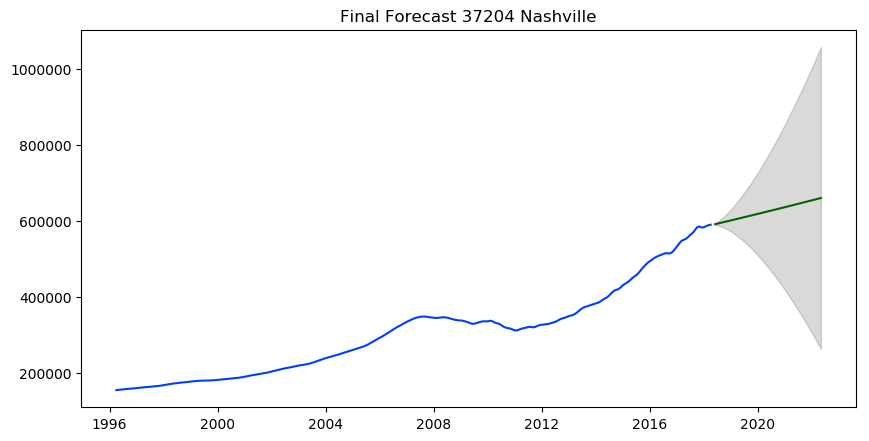

37204
Model Order:  (0, 2, 0)
Upside case 2022:  1058206.2039153255 ROI:  78.87110261790046
Base   case 2022:  660530.0380228111 ROI:  11.650957796537284
Low    case 2022:  262853.87213029666 ROI:  -55.569187024825894
Zip:  37206
ADF Statistic Residual: -5.778231
p-value: 0.000001


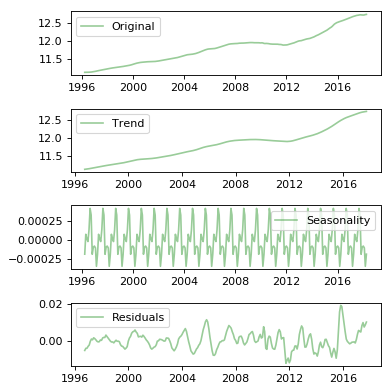

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4001.508, BIC=4015.797, Fit time=0.137 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4010.072, BIC=4017.217, Fit time=0.021 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4007.862, BIC=4018.579, Fit time=0.081 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4006.293, BIC=4017.009, Fit time=0.088 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=3989.857, BIC=4007.718, Fit time=0.408 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=3987.936, BIC=4002.224, Fit time=0.302 seconds
Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=3991.950, BIC=4013.383, Fit time=0.932 seconds
Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=3989.836, BIC=4007.697, Fit time=0.402 seconds
Total fit time: 2.387 seconds
37206
                           Statespace Model Results                           
Dep. Variable:               

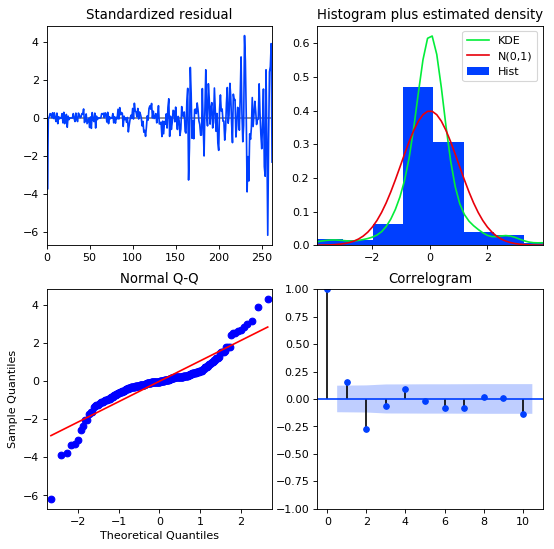

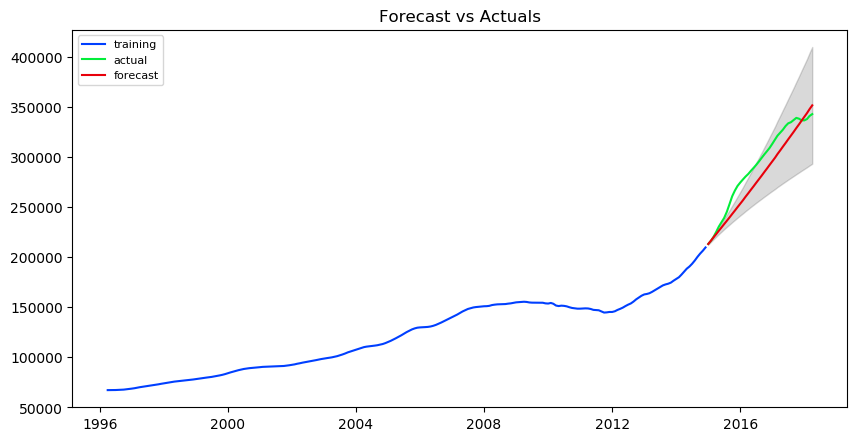

Mean Error : -11522.343762266533


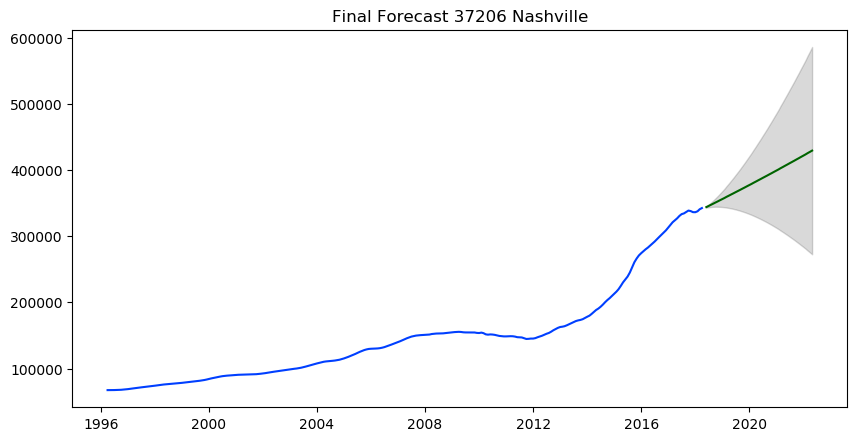

37206
Model Order:  (2, 2, 0)
Upside case 2022:  586604.3448464856 ROI:  70.38675866227162
Base   case 2022:  429735.42738842504 ROI:  24.822168806509133
Low    case 2022:  272866.5099303644 ROI:  -20.74242104925337
Zip:  80210
ADF Statistic Residual: -3.737206
p-value: 0.003619


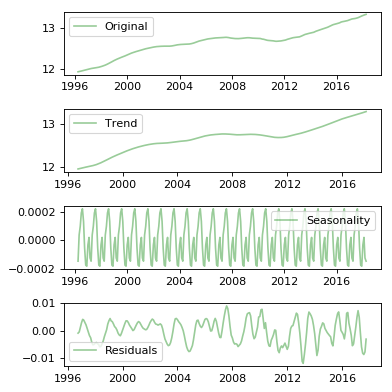

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4157.102, BIC=4171.391, Fit time=0.292 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4151.770, BIC=4158.914, Fit time=0.017 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4153.483, BIC=4164.199, Fit time=0.075 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4154.530, BIC=4165.246, Fit time=0.076 seconds
Total fit time: 0.474 seconds
80210
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -2073.885
Date:                Mon, 11 Nov 2019   AIC                           4151.770
Time:                        11:49:31   BIC                           4158.914
Sample:                             0   HQIC                          4154.641
                                - 265                         

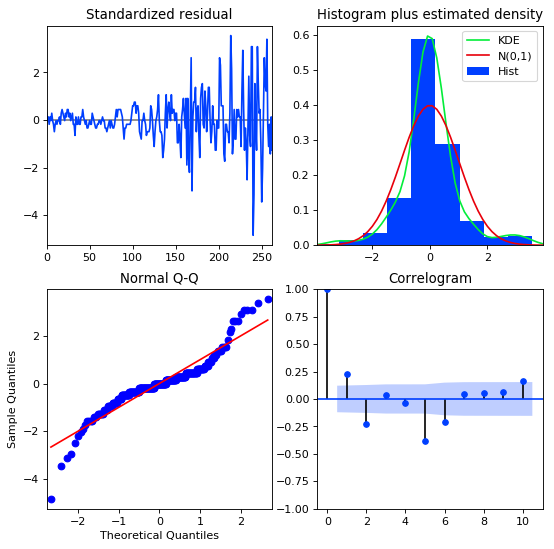

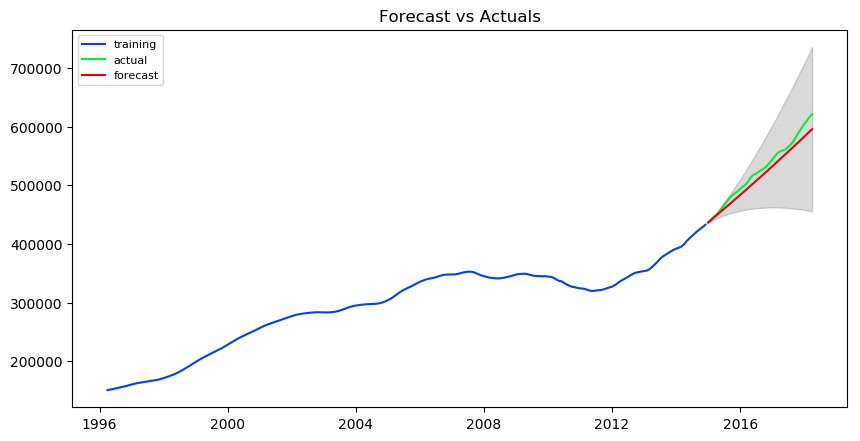

Mean Error : -10909.01345291477


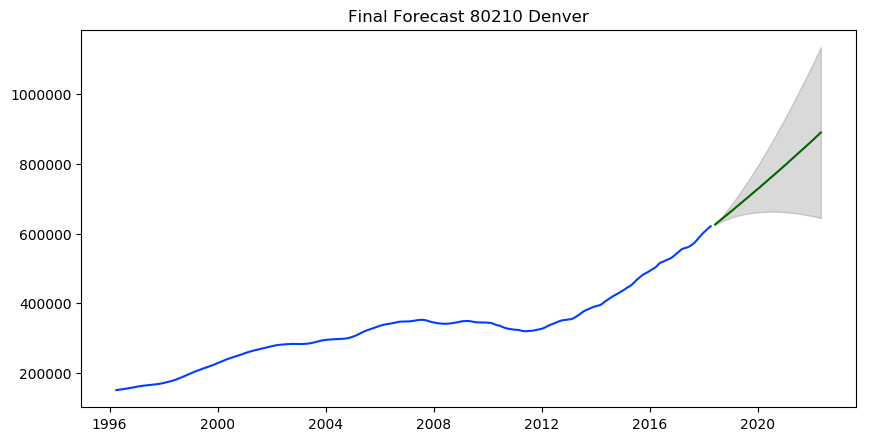

80210
Model Order:  (0, 2, 0)
Upside case 2022:  1136422.267123977 ROI:  81.38737764512824
Base   case 2022:  890574.5247148258 ROI:  42.14696623676396
Low    case 2022:  644726.7823056746 ROI:  2.9065548283996723
Zip:  80211
ADF Statistic Residual: -4.418188
p-value: 0.000276


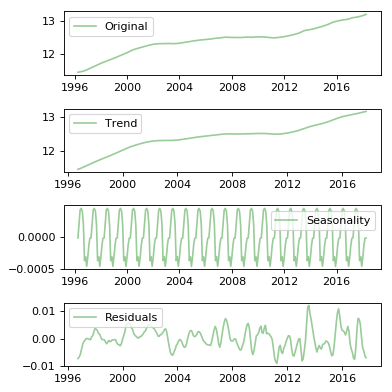

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4051.243, BIC=4065.531, Fit time=0.340 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4053.545, BIC=4060.689, Fit time=0.022 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4052.712, BIC=4063.428, Fit time=0.087 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4052.163, BIC=4062.879, Fit time=0.210 seconds
Fit ARIMA: order=(2, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4049.727, BIC=4067.587, Fit time=0.689 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4049.217, BIC=4063.505, Fit time=0.262 seconds
Fit ARIMA: order=(3, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=4053.322, BIC=4074.755, Fit time=0.758 seconds
Fit ARIMA: order=(3, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=4051.072, BIC=4068.933, Fit time=0.402 seconds
Total fit time: 2.787 seconds
80211
                           Statespace Model Results                           
Dep. Variable:               

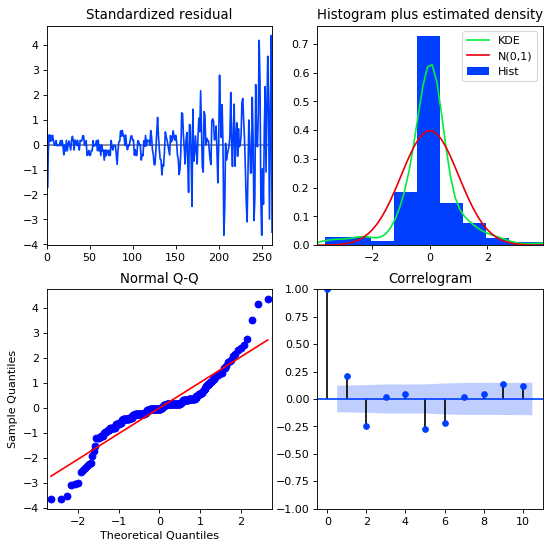

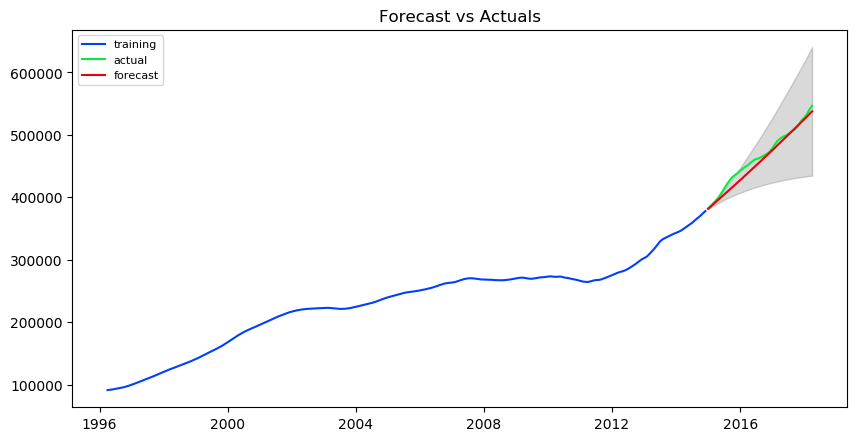

Mean Error : -6565.8490937489305


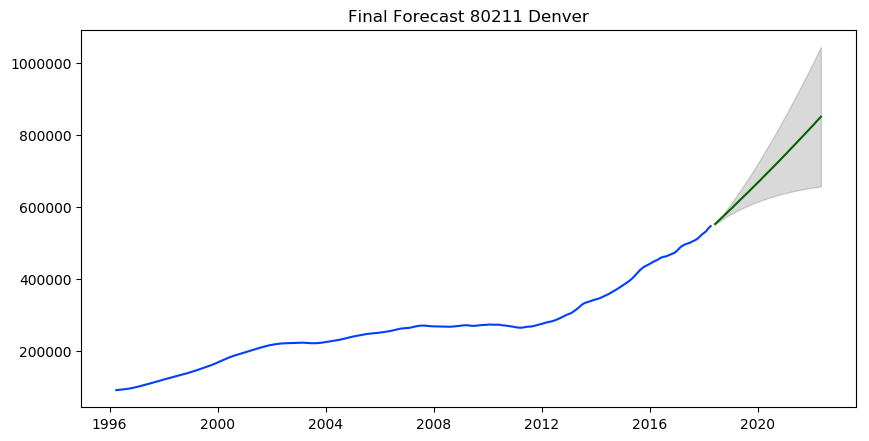

80211
Model Order:  (2, 2, 0)
Upside case 2022:  1043972.3593847754 ROI:  88.9985568686253
Base   case 2022:  850267.5571254173 ROI:  53.930647496852515
Low    case 2022:  656562.7548660592 ROI:  18.86273812507973
Zip:  80521
ADF Statistic Residual: -3.809518
p-value: 0.002811


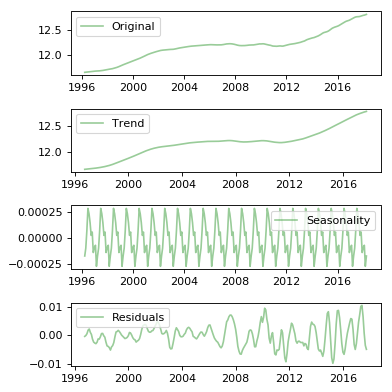

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=3869.610, BIC=3883.899, Fit time=0.306 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=3877.846, BIC=3884.991, Fit time=0.018 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 1); AIC=3869.604, BIC=3880.321, Fit time=0.277 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 1); AIC=3868.471, BIC=3879.188, Fit time=0.213 seconds
Fit ARIMA: order=(0, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=3868.553, BIC=3882.842, Fit time=0.335 seconds
Fit ARIMA: order=(1, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=3863.200, BIC=3881.061, Fit time=0.737 seconds
Fit ARIMA: order=(2, 2, 2) seasonal_order=(0, 0, 0, 1); AIC=3864.190, BIC=3885.623, Fit time=0.845 seconds
Fit ARIMA: order=(1, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=3864.249, BIC=3885.682, Fit time=0.843 seconds
Fit ARIMA: order=(2, 2, 3) seasonal_order=(0, 0, 0, 1); AIC=3866.892, BIC=3891.897, Fit time=0.913 seconds
Total fit time: 4.503 seconds
80521
 

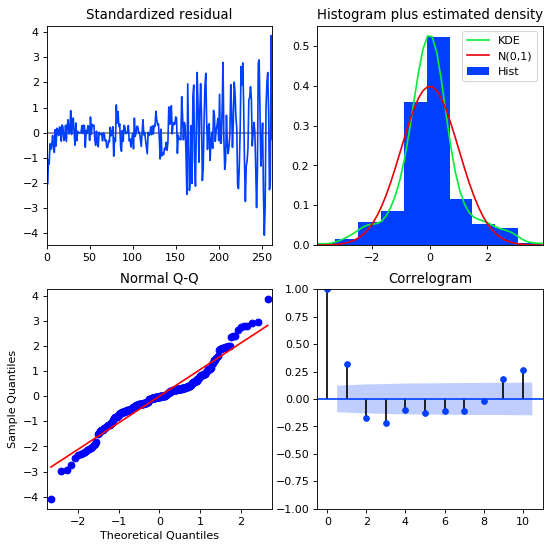

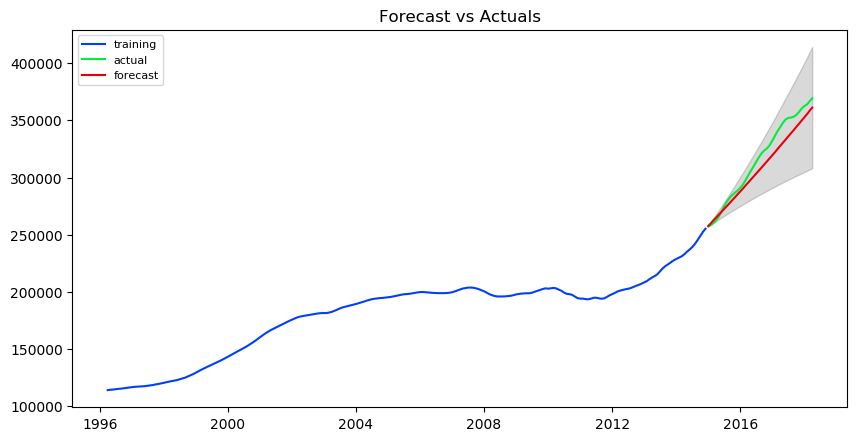

Mean Error : -8010.35953524049


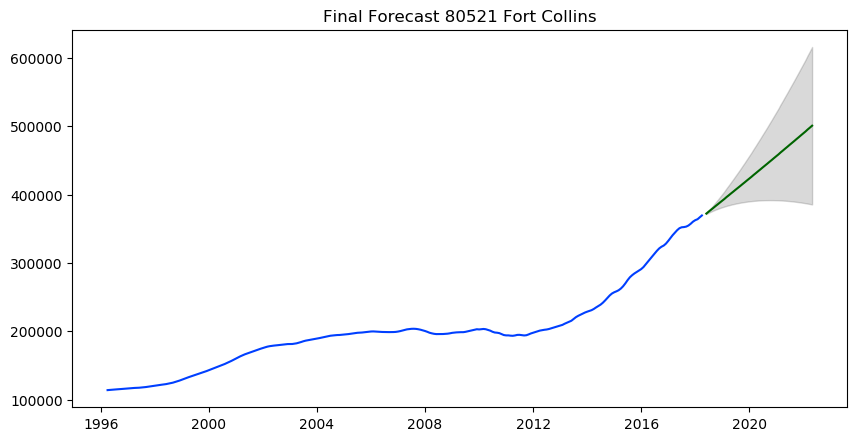

80521
Model Order:  (1, 2, 2)
Upside case 2022:  616130.4056734215 ROI:  65.51797431145992
Base   case 2022:  500875.97850227036 ROI:  34.55589365428787
Low    case 2022:  385621.5513311193 ROI:  3.593812997115827
Zip:  99502
ADF Statistic Residual: -6.172283
p-value: 0.000000


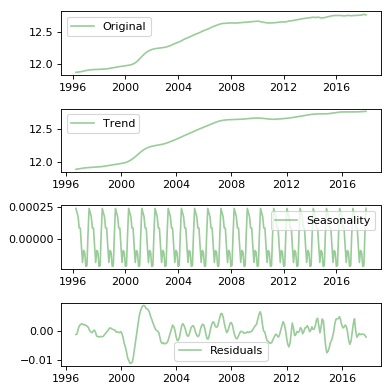

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=4348.597, BIC=4362.901, Fit time=0.380 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=4371.488, BIC=4378.639, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 1); AIC=4366.088, BIC=4376.816, Fit time=0.324 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=4366.680, BIC=4377.408, Fit time=0.216 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 0, 1); AIC=4350.546, BIC=4368.426, Fit time=0.587 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=4350.610, BIC=4368.490, Fit time=0.550 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 0, 0, 1); AIC=4355.083, BIC=4376.539, Fit time=0.912 seconds
Total fit time: 2.999 seconds
99502
                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                  265
Model:               SARIMAX(1, 1, 1)   Log Likelihood   

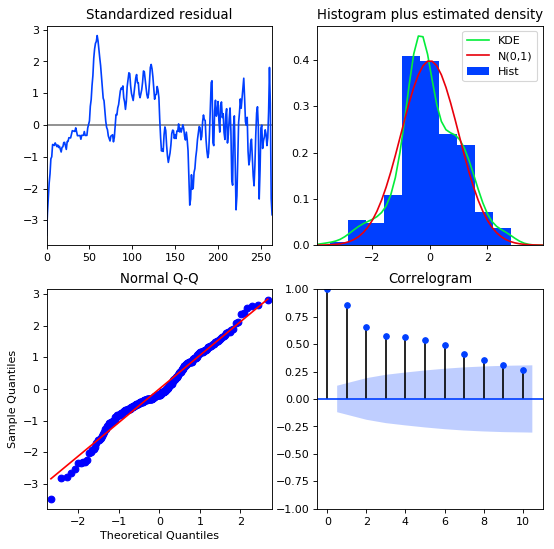

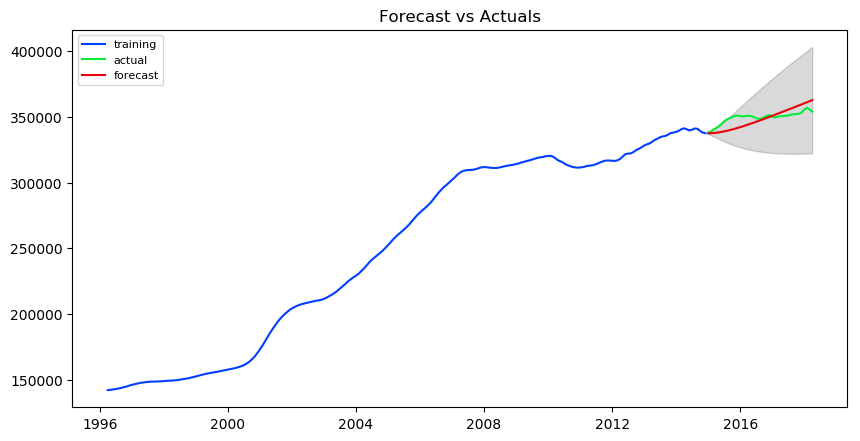

Mean Error : -1266.6287856179217


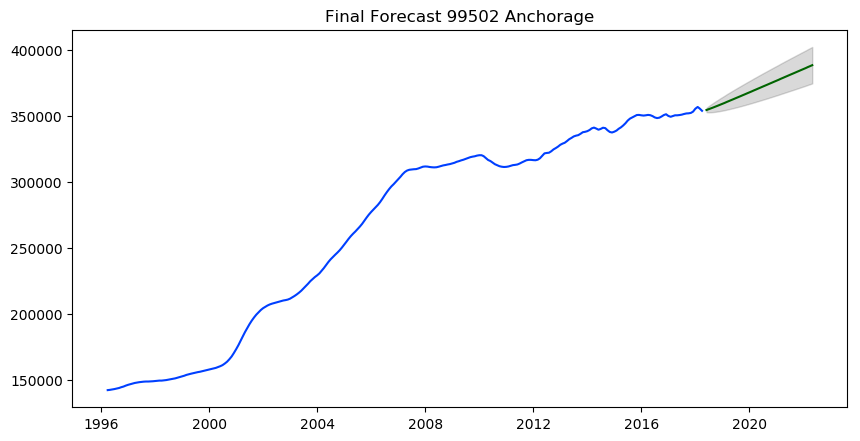

99502
Model Order:  (1, 1, 1)
Upside case 2022:  402120.970178168 ROI:  13.464154399553358
Base   case 2022:  388319.8307067016 ROI:  9.569966490908826
Low    case 2022:  374518.69123523525 ROI:  5.675778582264296


In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose

residuals_list = []
for z in zipcodes1: 
    df_z = zippedf[zippedf.RegionName == z]
    ts = df_z.value
    decomposition = seasonal_decompose(np.log(ts))

    # Gather the trend, seasonality and noise of decomposed object
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    df_z['res'] = residual
    residuals_list.append(residual)
    
    # Plot gathered statistics
    plt.figure(figsize=(5,5))
    plt.subplot(411)
    plt.plot(np.log(ts), label='Original', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='green',alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    result = adfuller(residual.dropna())
    print('Zip: ', z)
    print('ADF Statistic Residual: %f' % result[0])
    print('p-value: %f' % result[1])
    plt.show()
    

    model = pm.auto_arima(df_z.value.dropna(), start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   #  Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
    print(z)
    print(model.summary())
    model.plot_diagnostics(figsize=(8, 8))
    plt.show()
    
    #============= PLOT TRAIN AND TEST =========
    #df_z.reset_index(inplace=True)
    train = df_z.value.dropna()[:225]
    test = df_z.value.dropna()[225:]
    
    test_index = zippedf.index[-40:]
    model2 = ARIMA(train, order=model.order)
    fitted = model2.fit(disp=-1)  
                   
    # Forecast
    fc, se, conf = fitted.forecast(40, alpha=0.05)  # 95% conf

    # Make as pandas series
    fc_series = pd.Series(fc, index=test_index)
    lower_series = pd.Series(conf[:, 0], index=test_index)
    upper_series = pd.Series(conf[:, 1], index=test_index)

    # Plot
    plt.figure(figsize=(10,5), dpi=100)
    plt.plot(train, label='training')
    plt.plot(test, label='actual')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, 
                     color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    print('Mean Error :', np.mean(fc_series - test))
    
    
    #==============PLOT FORECAST =========================
    #df_z.reset_index(inplace=True)
    n_periods = 48
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    #index_of_fc = np.arange(len(df_z.value), len(df_z.value)+n_periods)
    
    index_of_fc = pd.date_range('2018-05-01', periods=48, freq='M')
    # make series for plotting purpose
    fc_series = pd.Series(fc, index=(index_of_fc))
    lower_series = pd.Series(confint[:, 0], index=(index_of_fc))
    upper_series = pd.Series(confint[:, 1], index=(index_of_fc))

    # Plot
    plt.figure(figsize=(10,5), dpi=100)

    plt.plot(fc_series, color='darkgreen')
    plt.plot(df_z.value)
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color='k', alpha=.15)

    plt.title("Final Forecast " + str(z) + ' ' + df_z.City[0])
    plt.show()
    print(z)
    print('Model Order: ', model.order)
    print('Upside case 2022: ', upper_series[-1], 'ROI: ', (upper_series[-1]-fc_series[-48])/fc_series[-48]*100)
    print('Base   case 2022: ', fc_series[-1], 'ROI: ', (fc_series[-1]-fc_series[-48])/fc_series[-48]*100)
    print('Low    case 2022: ', lower_series[-1], 'ROI: ', (lower_series[-1]-fc_series[-48])/fc_series[-48]*100)

# Step 6: Interpreting Results

Our top zip codes are 37204 Nashville, with an upside case of 1,006,000, and ROI statistic of 78.88 - 37206 Nashville with an upside case of approximately 587000 and ROI of 70.39, 80210 Denver wiht an upside case of approximately 1,146,000 and an ROI of 81.39 - 80211 Denver with an upside case of approximately 1,043,972 and an upside case of ROI 88.99 - 80521 Fort Collins with an upside case of 616,130 and an ROI of 65.51 

Zipcodes in Denver and Nashville returned the best results, and slightly out performed forecasts. Recommendations: Invest in Denver and Nashville.

# The Next Step

If more time and resources were available we would recommend investigating other economical factors, and not relying solely on historical trends in price
Areas to investigate would be local economies, qualities of schools, and economic trends in the housing market such as resell rates
